## 04 - Avaliação e Comparação dos Modelos

Avaliar performance dos modelos no conjunto de teste

# Imports

In [13]:
import sys
sys.path.append('/home/jovyan/work')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src import S3Client, ModelEvaluator, MLFlowClient, DatabaseClient

# Carregar dados de teste

In [14]:
s3 = S3Client()

X_test = s3.read_csv('processed/X_test_scaled.csv')
y_test = s3.read_csv('processed/y_test.csv')['target']

print(f"📊 X_test: {X_test.shape}")
print(f"📊 y_test: {y_test.shape}")

INFO:src.s3_utils:S3 Client inicializado: http://minio:9000/ml-bucket-heart
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/X_test_scaled.csv (232 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/y_test.csv (232 linhas)


📊 X_test: (232, 19)
📊 y_test: (232,)


# Inicializar evaluator e MLFlow

In [15]:
evaluator = ModelEvaluator()
mlflow_client = MLFlowClient(experiment_name="heart-disease-prediction")

INFO:src.model_evaluation:ModelEvaluator inicializado
INFO:src.mlflow_utils:✅ Experimento existente: heart-disease-prediction
INFO:src.mlflow_utils:MLFlow Client inicializado: http://mlflow:5000


# Carregar Modelos Treinados do MLFlow

In [16]:
print("📋 Buscando modelos no MinIO...")

# Estrutura: ml-bucket-heart/models/{model_name}/{id}/model.pkl
model_names = ['knn', 'random_forest', 'logistic_regression', 
               'svm', 'naive_bayes', 'decision_tree',
               'gradient_boosting', 'random_forest_tuned']

# Dicionário para armazenar caminhos dos modelos
models_paths = {}

for model_name in model_names:
    try:
        # Listar arquivos dentro de models/{model_name}/
        prefix = f'models/{model_name}/'
        files = s3.list_files(prefix)
        
        # Filtrar apenas .pkl
        pkl_files = [f for f in files if f.endswith('.pkl')]
        
        if pkl_files:
            # Pegar o último (mais recente por ID)
            pkl_files_sorted = sorted(pkl_files)
            latest_model = pkl_files_sorted[-1]
            models_paths[model_name] = latest_model
            print(f"   ✅ {model_name}: {latest_model}")
        else:
            print(f"   ⚠️ {model_name}: Nenhum arquivo .pkl encontrado")
            
    except Exception as e:
        print(f"   ❌ {model_name}: Erro ao buscar - {str(e)}")

print(f"\n📦 Total de modelos encontrados: {len(models_paths)}")

INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/knn/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/random_forest/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/logistic_regression/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/svm/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/naive_bayes/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/decision_tree/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/gradient_boosting/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/random_forest_tuned/'


📋 Buscando modelos no MinIO...
   ✅ knn: models/knn/5459f567315b464a9b3126f07aaaf2be.pkl
   ✅ random_forest: models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
   ✅ logistic_regression: models/logistic_regression/7a52894d78744d85933381d1dd6f537d.pkl
   ✅ svm: models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
   ✅ naive_bayes: models/naive_bayes/d3402fda1dc84e41a40cfe78ce86926a.pkl
   ✅ decision_tree: models/decision_tree/e0f42c9e61ad4b019bbabf65d0643ced.pkl
   ✅ gradient_boosting: models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
   ✅ random_forest_tuned: models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl

📦 Total de modelos encontrados: 8


# Avaliar Modelos do Artigo

In [17]:
results = []

for model_name, model_path in models_paths.items():
    try:
        print(f"\n🔄 Avaliando: {model_name}")
        print(f"   📂 Carregando de: {model_path}")
        
        # Carregar modelo do MinIO
        model = s3.load_model(model_path)
        
        if model is None:
            print(f"   ⚠️ Modelo não carregado: {model_name}")
            continue
        
        # Predições
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
        
        # Avaliar
        metrics = evaluator.evaluate_model(
            y_test, 
            y_pred, 
            y_pred_proba,
            model_name=model_name
        )
        
        results.append(metrics)
        
        print(f"   ✅ Accuracy: {metrics['accuracy']:.4f}")
        
        # Salvar métricas no banco
        try:
            db = DatabaseClient()
            db.insert_model_metrics(
                model_name=model_name,
                model_version="1",
                metrics=metrics
            )
        except Exception as db_error:
            print(f"   ⚠️ Erro ao salvar no banco: {str(db_error)}")
        
    except Exception as e:
        print(f"   ❌ Erro ao avaliar {model_name}: {str(e)}")

print(f"\n✅ {len(results)} modelos avaliados com sucesso!")

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/knn/5459f567315b464a9b3126f07aaaf2be.pkl



🔄 Avaliando: knn
   📂 Carregando de: models/knn/5459f567315b464a9b3126f07aaaf2be.pkl


INFO:src.model_evaluation:📊 Avaliando modelo: knn
INFO:src.model_evaluation:✅ Accuracy: 0.8448
INFO:src.model_evaluation:✅ Precision: 0.8448
INFO:src.model_evaluation:✅ Recall: 0.8448
INFO:src.model_evaluation:✅ F1-Score: 0.8448
INFO:src.model_evaluation:✅ ROC AUC: 0.9092
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db


   ✅ Accuracy: 0.8448


INFO:src.db_utils:✅ Query executada com sucesso
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl



🔄 Avaliando: random_forest
   📂 Carregando de: models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl


INFO:src.model_evaluation:📊 Avaliando modelo: random_forest
INFO:src.model_evaluation:✅ Accuracy: 0.9138
INFO:src.model_evaluation:✅ Precision: 0.9138
INFO:src.model_evaluation:✅ Recall: 0.9138
INFO:src.model_evaluation:✅ F1-Score: 0.9138
INFO:src.model_evaluation:✅ ROC AUC: 0.9435
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_utils:✅ Query executada com sucesso
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/logistic_regression/7a52894d78744d85933381d1dd6f537d.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: logistic_regression


   ✅ Accuracy: 0.9138

🔄 Avaliando: logistic_regression
   📂 Carregando de: models/logistic_regression/7a52894d78744d85933381d1dd6f537d.pkl


INFO:src.model_evaluation:✅ Accuracy: 0.8621
INFO:src.model_evaluation:✅ Precision: 0.8621
INFO:src.model_evaluation:✅ Recall: 0.8621
INFO:src.model_evaluation:✅ F1-Score: 0.8621
INFO:src.model_evaluation:✅ ROC AUC: 0.9278
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_utils:✅ Query executada com sucesso
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: svm
INFO:src.model_evaluation:✅ Accuracy: 0.8707
INFO:src.model_evaluation:✅ Precision: 0.8707
INFO:src.model_evaluation:✅ Recall: 0.8707
INFO:src.model_evaluation:✅ F1-Score: 0.8707
INFO:src.model_evaluation:✅ ROC AUC: 0.9341
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_utils:✅ Query executada com sucesso


   ✅ Accuracy: 0.8621

🔄 Avaliando: svm
   📂 Carregando de: models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
   ✅ Accuracy: 0.8707


INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/naive_bayes/d3402fda1dc84e41a40cfe78ce86926a.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: naive_bayes
INFO:src.model_evaluation:✅ Accuracy: 0.6509
INFO:src.model_evaluation:✅ Precision: 0.7785
INFO:src.model_evaluation:✅ Recall: 0.6509
INFO:src.model_evaluation:✅ F1-Score: 0.6181
INFO:src.model_evaluation:✅ ROC AUC: 0.9054
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_utils:✅ Query executada com sucesso
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/decision_tree/e0f42c9e61ad4b019bbabf65d0643ced.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: decision_tree
INFO:src.model_evaluation:✅ Accuracy: 0.8190
INFO:src.model_evaluation:✅ Precision: 0.8190
INFO:src.model_evaluation:✅ Recall: 0.8190
INFO:src.model_evaluation:✅ F1-Score: 0.8190
INFO:src.model_evaluation:✅ ROC AUC: 0.8306
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_


🔄 Avaliando: naive_bayes
   📂 Carregando de: models/naive_bayes/d3402fda1dc84e41a40cfe78ce86926a.pkl
   ✅ Accuracy: 0.6509

🔄 Avaliando: decision_tree
   📂 Carregando de: models/decision_tree/e0f42c9e61ad4b019bbabf65d0643ced.pkl
   ✅ Accuracy: 0.8190

🔄 Avaliando: gradient_boosting
   📂 Carregando de: models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
   ✅ Accuracy: 0.9052


INFO:src.db_utils:✅ Query executada com sucesso
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: random_forest_tuned



🔄 Avaliando: random_forest_tuned
   📂 Carregando de: models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl


INFO:src.model_evaluation:✅ Accuracy: 0.9138
INFO:src.model_evaluation:✅ Precision: 0.9138
INFO:src.model_evaluation:✅ Recall: 0.9138
INFO:src.model_evaluation:✅ F1-Score: 0.9137
INFO:src.model_evaluation:✅ ROC AUC: 0.9440
INFO:src.db_utils:Database Client inicializado: postgres:5432/mlflow_db
INFO:src.db_utils:✅ Query executada com sucesso


   ✅ Accuracy: 0.9138

✅ 8 modelos avaliados com sucesso!


# Comparação de Modelos

INFO:src.model_evaluation:📊 Comparação de 8 modelos:
INFO:src.model_evaluation:
            model_name  accuracy  precision    recall  f1_score
1        random_forest  0.913793   0.913793  0.913793  0.913793
7  random_forest_tuned  0.913793   0.913814  0.913793  0.913735
6    gradient_boosting  0.905172   0.905180  0.905172  0.905109
3                  svm  0.870690   0.870690  0.870690  0.870690
2  logistic_regression  0.862069   0.862069  0.862069  0.862069
0                  knn  0.844828   0.844828  0.844828  0.844828
5        decision_tree  0.818966   0.818966  0.818966  0.818966
4          naive_bayes  0.650862   0.778468  0.650862  0.618131



📊 Comparação de Modelos:


,model_name,accuracy,precision,recall,f1_score,roc_auc
1,random_forest,0.913793,0.913793,0.913793,0.913793,0.943511
7,random_forest_tuned,0.913793,0.913814,0.913793,0.913735,0.943959
6,gradient_boosting,0.905172,0.905180,0.905172,0.905109,0.937948
3,svm,0.870690,0.870690,0.870690,0.870690,0.934140
2,logistic_regression,0.862069,0.862069,0.862069,0.862069,0.927793
0,knn,0.844828,0.844828,0.844828,0.844828,0.909162
5,decision_tree,0.818966,0.818966,0.818966,0.818966,0.830608
4,naive_bayes,0.650862,0.778468,0.650862,0.618131,0.905391


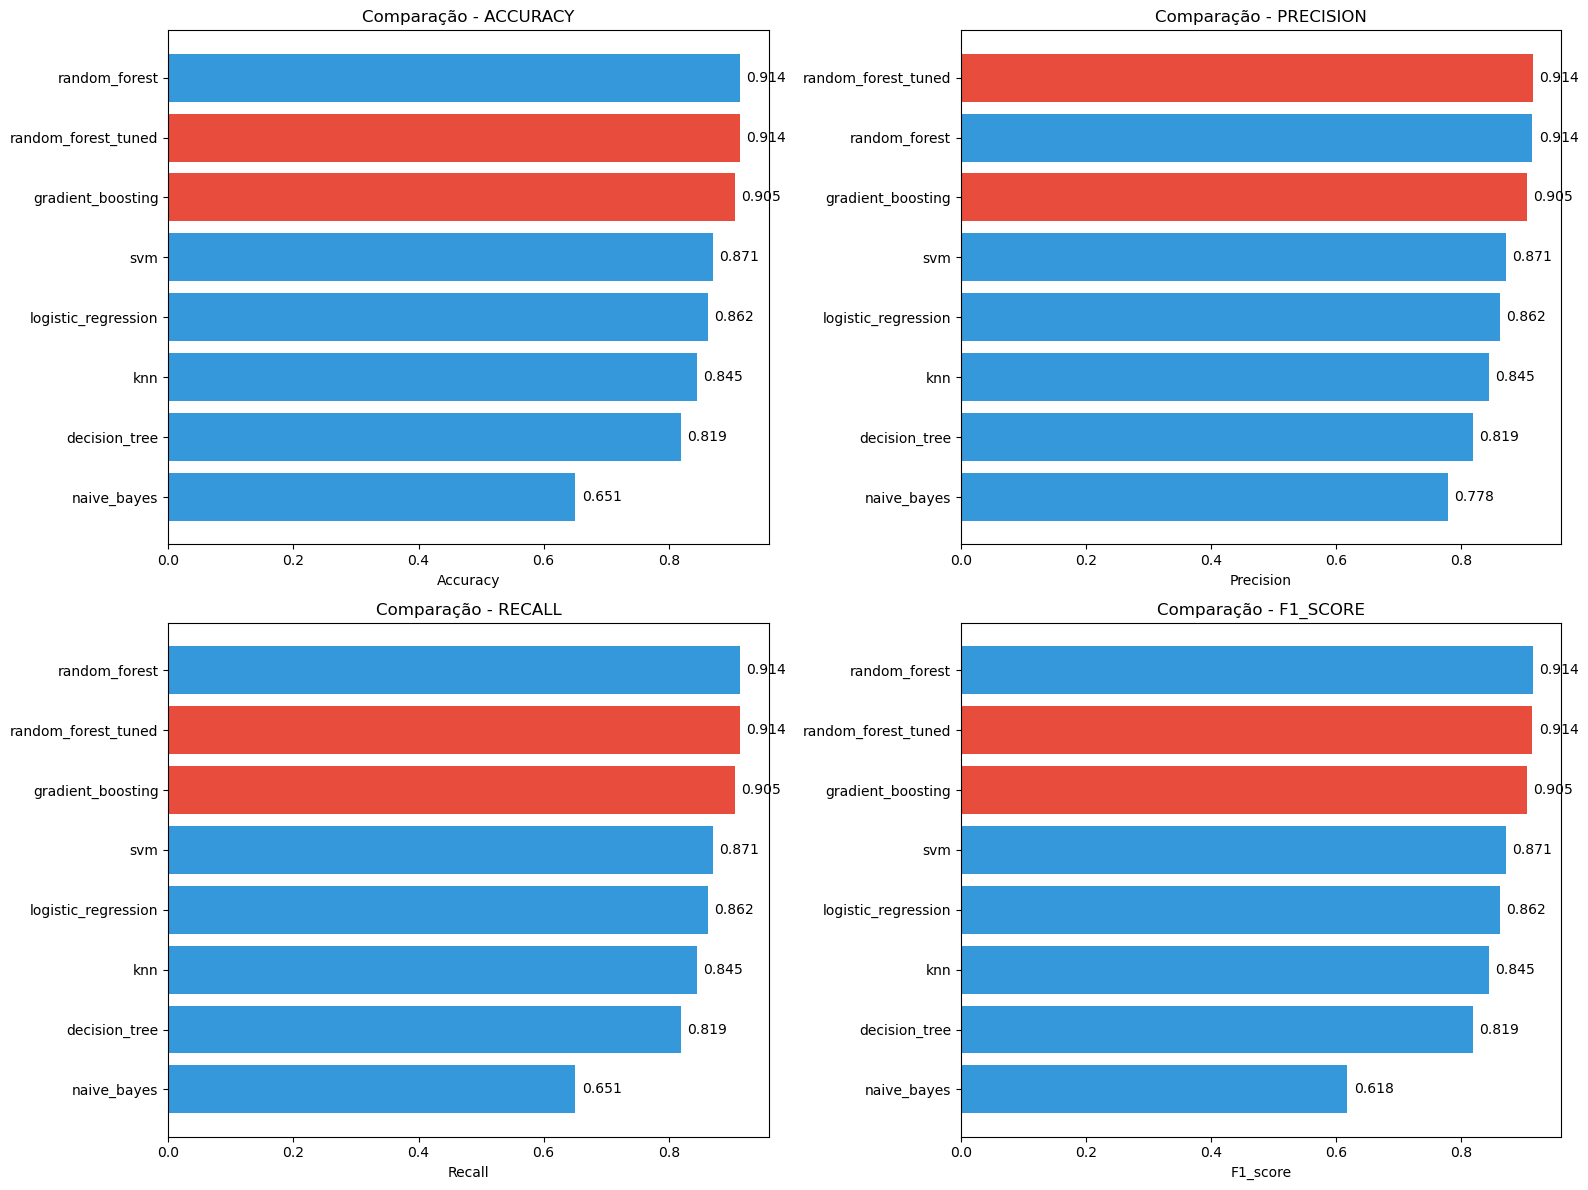

In [18]:
if len(results) == 0:
    print("❌ Nenhum modelo foi avaliado. Verifique os erros acima.")
else:
    comparison_df = evaluator.compare_models(results)

    print("\n📊 Comparação de Modelos:")
    display(comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

    # %% Visualizar comparação
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Modelos do artigo vs melhorias
    article_models = ['knn', 'random_forest', 'logistic_regression', 
                      'svm', 'naive_bayes', 'decision_tree']

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        # Ordenar por métrica
        df_sorted = comparison_df.sort_values(metric, ascending=False)
        
        # Cores diferentes para modelos do artigo vs melhorias
        colors = ['#3498db' if name in article_models else '#e74c3c' 
                  for name in df_sorted['model_name']]
        
        ax.barh(df_sorted['model_name'], df_sorted[metric], color=colors)
        ax.set_xlabel(metric.capitalize())
        ax.set_title(f'Comparação - {metric.upper()}')
        ax.invert_yaxis()
        
        # Adicionar valores
        for i, v in enumerate(df_sorted[metric]):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center')

    plt.tight_layout()
    plt.show()

# Melhor Modelo

In [19]:
if len(results) > 0:
    best_metrics = evaluator.get_best_model_metrics(metric='accuracy')

    print(f"\n🏆 Melhor Modelo: {best_metrics['model_name']}")
    print(f"   Accuracy:  {best_metrics['accuracy']:.4f}")
    print(f"   Precision: {best_metrics['precision']:.4f}")
    print(f"   Recall:    {best_metrics['recall']:.4f}")
    print(f"   F1-Score:  {best_metrics['f1_score']:.4f}")
    if best_metrics.get('roc_auc'):
        print(f"   ROC AUC:   {best_metrics['roc_auc']:.4f}")

INFO:src.model_evaluation:🏆 Melhor modelo (accuracy): random_forest
INFO:src.model_evaluation:   accuracy: 0.9138



🏆 Melhor Modelo: random_forest
   Accuracy:  0.9138
   Precision: 0.9138
   Recall:    0.9138
   F1-Score:  0.9138
   ROC AUC:   0.9435


## Matrizes de Confusão

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
INFO:src.model_evaluation:📊 Matriz de Confusão:
[[ 98  10]
 [ 10 114]]
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl
INFO:src.model_evaluation:📊 Matriz de Confusão:
[[ 97  11]
 [  9 115]]
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
INFO:src.model_evaluation:📊 Matriz de Confusão:
[[ 96  12]
 [ 10 114]]
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
INFO:src.model_evaluation:📊 Matriz de Confusão:
[[ 93  15]
 [ 15 109]]


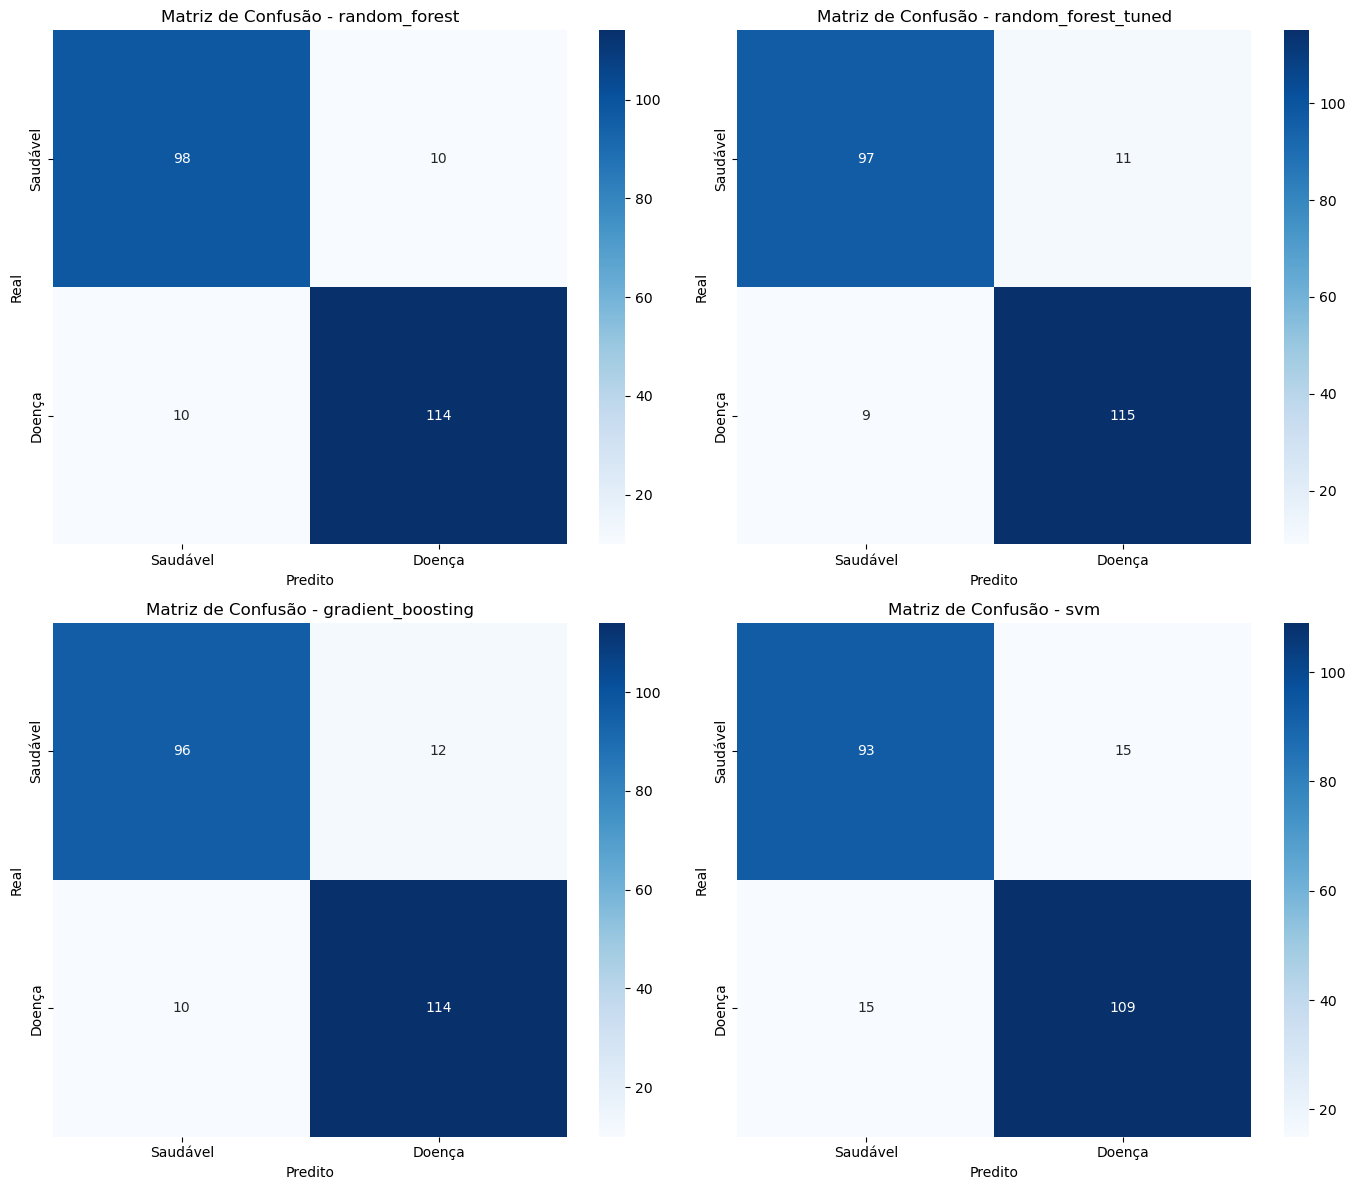

In [20]:
if len(results) >= 4:
    top_4_models = comparison_df.head(4)['model_name'].tolist()
else:
    top_4_models = [r['model_name'] for r in results[:min(4, len(results))]]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_4_models):
    try:
        # Buscar caminho do modelo
        if model_name in models_paths:
            model_path = models_paths[model_name]
            
            # Carregar modelo
            model = s3.load_model(model_path)
            
            if model is None:
                continue
            
            # Predições
            y_pred = model.predict(X_test)
            
            # Matriz de confusão
            cm = evaluator.get_confusion_matrix(y_test, y_pred)
            
            # Plotar
            ax = axes[idx]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Saudável', 'Doença'],
                       yticklabels=['Saudável', 'Doença'])
            ax.set_title(f'Matriz de Confusão - {model_name}')
            ax.set_ylabel('Real')
            ax.set_xlabel('Predito')
        
    except Exception as e:
        print(f"❌ Erro ao plotar CM para {model_name}: {str(e)}")

plt.tight_layout()
plt.show()

## Curvas ROC

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
INFO:src.model_evaluation:✅ ROC Curve calculada (AUC: 0.9435)
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl
INFO:src.model_evaluation:✅ ROC Curve calculada (AUC: 0.9440)
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
INFO:src.model_evaluation:✅ ROC Curve calculada (AUC: 0.9379)
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
INFO:src.model_evaluation:✅ ROC Curve calculada (AUC: 0.9341)


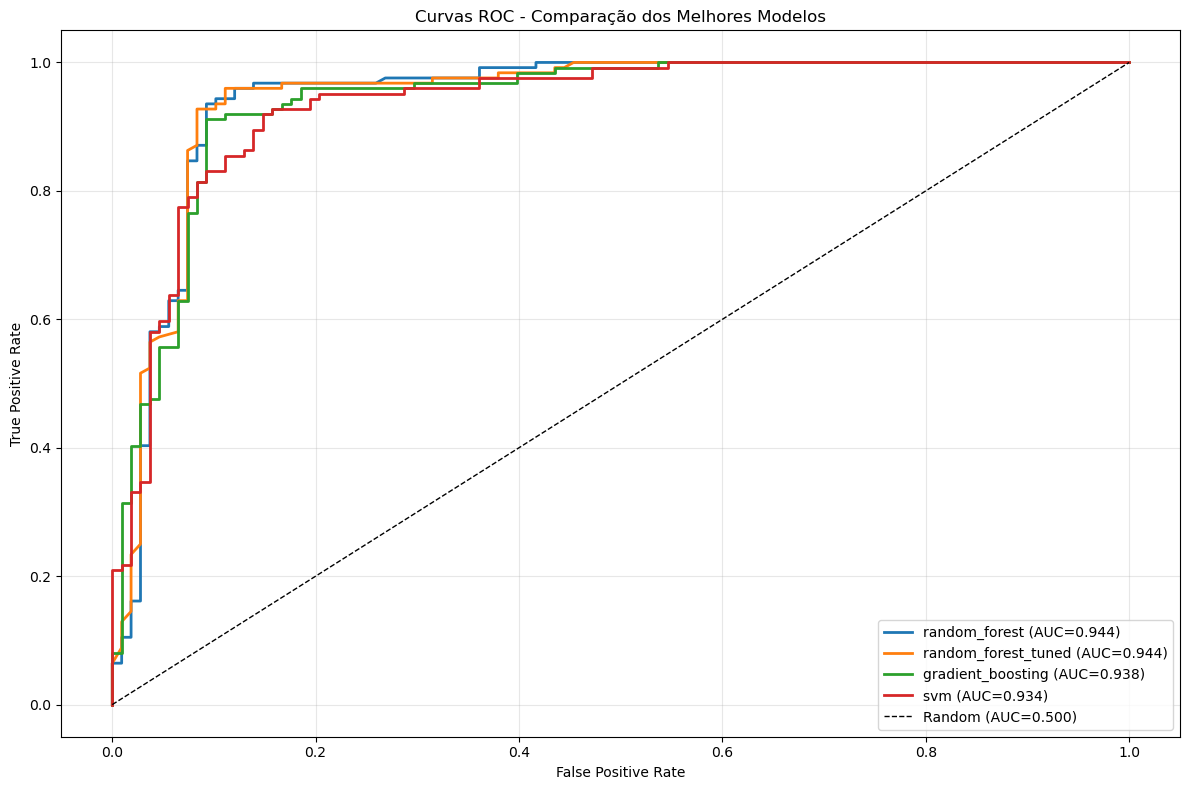

In [21]:
plt.figure(figsize=(12, 8))

models_to_plot = top_4_models if len(results) >= 4 else [r['model_name'] for r in results]

for model_name in models_to_plot:
    try:
        # Carregar modelo
        if model_name in models_paths:
            model = s3.load_model(models_paths[model_name])
            
            if model is None:
                continue
            
            # Probabilidades
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)
                
                # Calcular ROC
                roc_data = evaluator.calculate_roc_curve(y_test, y_pred_proba)
                
                if roc_data:
                    plt.plot(roc_data['fpr'], roc_data['tpr'], 
                            label=f"{model_name} (AUC={roc_data['auc']:.3f})",
                            linewidth=2)
        
    except Exception as e:
        print(f"❌ Erro ao plotar ROC para {model_name}: {str(e)}")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparação dos Melhores Modelos')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Classification Reports

In [22]:
if len(results) >= 3:
    print("\n" + "="*60)
    print("📊 CLASSIFICATION REPORTS - TOP 3 MODELOS")
    print("="*60)

    for model_name in comparison_df.head(3)['model_name']:
        try:
            # Carregar modelo
            if model_name in models_paths:
                model = s3.load_model(models_paths[model_name])
                
                # Predições
                y_pred = model.predict(X_test)
                
                # Report
                print(f"\n{'='*60}")
                print(f"MODELO: {model_name.upper()}")
                print(f"{'='*60}")
                
                report = evaluator.get_classification_report(
                    y_test, 
                    y_pred,
                    target_names=['Saudável (0)', 'Doença (1)']
                )
            
        except Exception as e:
            print(f"❌ Erro: {str(e)}")

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
INFO:src.model_evaluation:📊 Classification Report:
              precision    recall  f1-score   support

Saudável (0)       0.91      0.91      0.91       108
  Doença (1)       0.92      0.92      0.92       124

    accuracy                           0.91       232
   macro avg       0.91      0.91      0.91       232
weighted avg       0.91      0.91      0.91       232

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl
INFO:src.model_evaluation:📊 Classification Report:
              precision    recall  f1-score   support

Saudável (0)       0.92      0.90      0.91       108
  Doença (1)       0.91      0.93      0.92       124

    accuracy                           0.91       232
   macro avg       0.91      0.91      0.91       232
weighted avg       0.91      0.91      0.91       232

INFO


📊 CLASSIFICATION REPORTS - TOP 3 MODELOS

MODELO: RANDOM_FOREST

MODELO: RANDOM_FOREST_TUNED

MODELO: GRADIENT_BOOSTING


### Feature Importance (Top 3 Tree-based Models)

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/decision_tree/e0f42c9e61ad4b019bbabf65d0643ced.pkl
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl


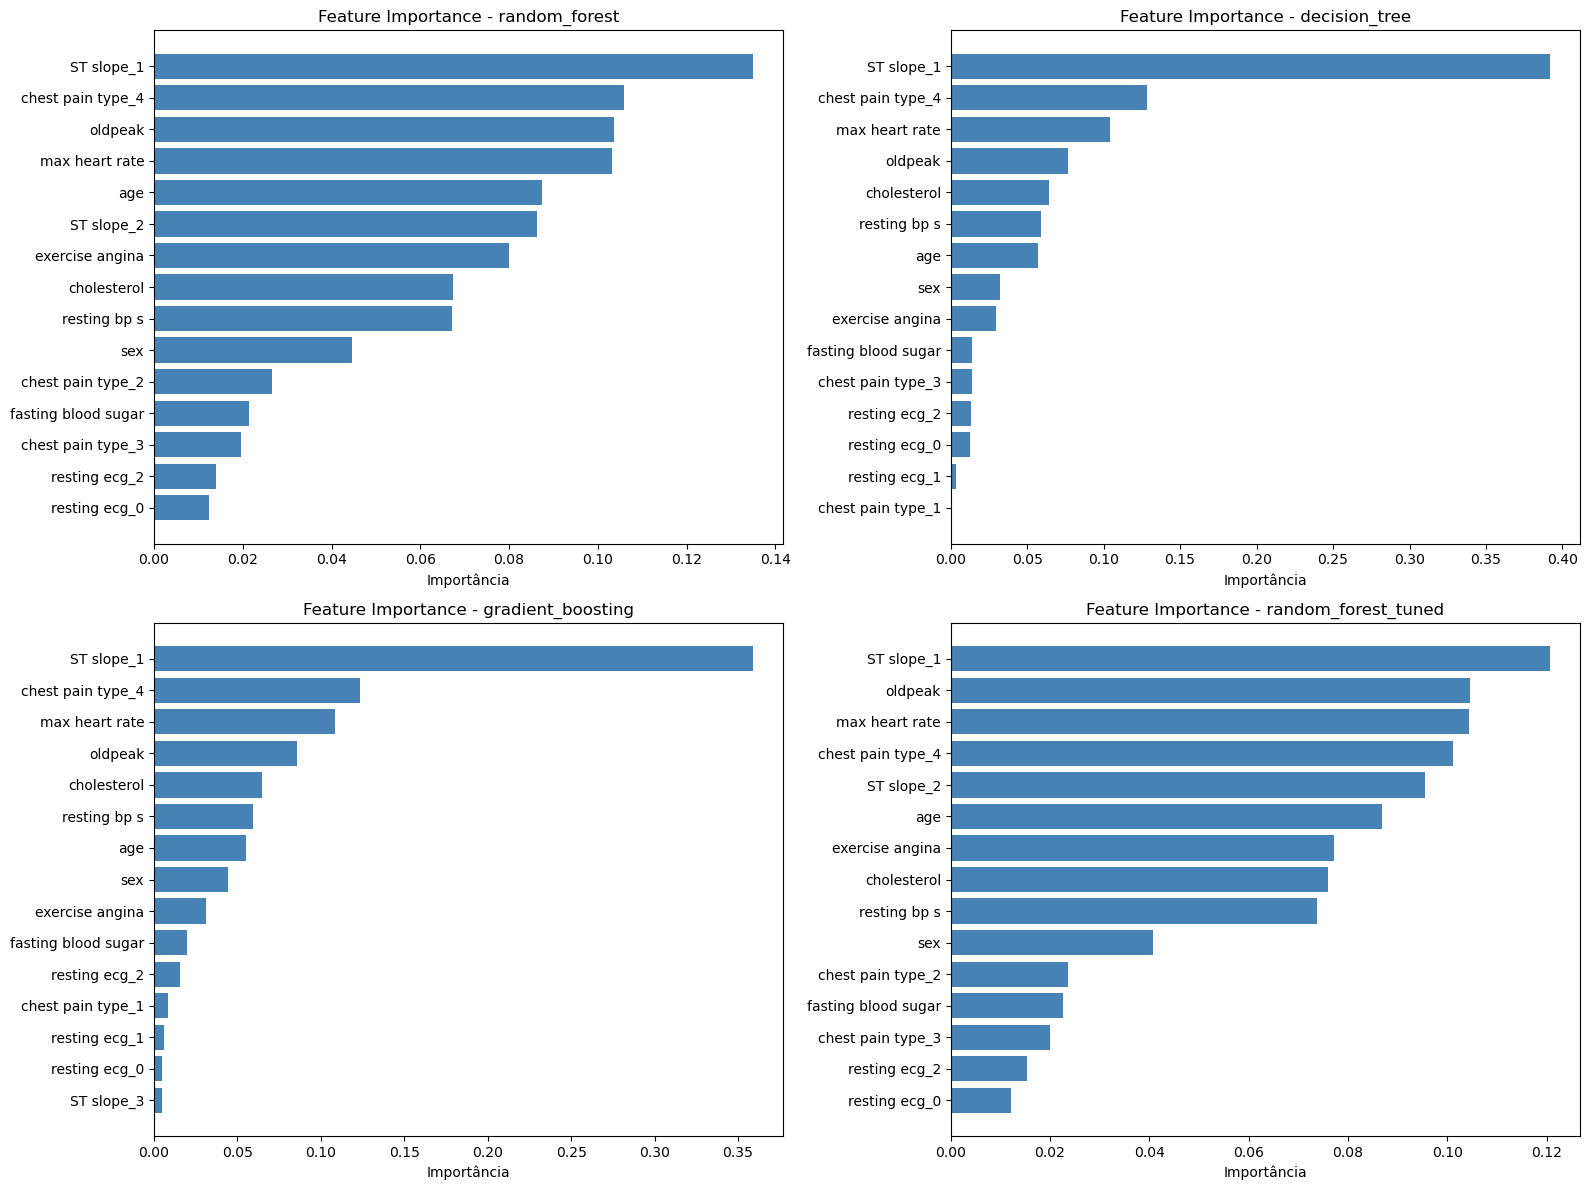

In [23]:
tree_models = ['random_forest', 'decision_tree', 'gradient_boosting', 'random_forest_tuned']
available_tree_models = [m for m in tree_models if m in models_paths]

if available_tree_models:
    n_models = len(available_tree_models)
    n_cols = 2
    n_rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    feature_names = X_test.columns.tolist()

    for idx, model_name in enumerate(available_tree_models):
        try:
            # Carregar modelo
            model = s3.load_model(models_paths[model_name])
            
            if hasattr(model, 'feature_importances_'):
                # Feature importance
                importances = model.feature_importances_
                
                # Criar DataFrame
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False).head(15)
                
                # Plotar
                ax = axes[idx]
                ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
                ax.set_xlabel('Importância')
                ax.set_title(f'Feature Importance - {model_name}')
                ax.invert_yaxis()
            
        except Exception as e:
            print(f"❌ Erro ao plotar FI para {model_name}: {str(e)}")

    # Esconder eixos extras
    for idx in range(len(available_tree_models), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Exportar Resultados

In [27]:
if len(results) > 0:
    # Criar DataFrame com as métricas
    metrics_df = pd.DataFrame(results)
    
    # Salvar direto no MinIO usando write_csv
    s3.write_csv(metrics_df, 'models/model_metrics.csv')
    
    print("✅ Métricas exportadas para MinIO!")
    print(f"📊 Total de modelos exportados: {len(metrics_df)}")

INFO:src.s3_utils:✅ CSV salvo: s3://ml-bucket-heart/models/model_metrics.csv


✅ Métricas exportadas para MinIO!
📊 Total de modelos exportados: 8


# Resumo Final

In [25]:
if len(results) > 0:
    summary = evaluator.get_metrics_summary()

    print("\n📊 Resumo Estatístico das Métricas:")
    display(summary[['accuracy', 'precision', 'recall', 'f1_score']])

    # %% Comparação Artigo vs Melhorias
    print("\n📊 Comparação: Modelos do Artigo vs Melhorias")

    article_models = ['knn', 'random_forest', 'logistic_regression', 
                      'svm', 'naive_bayes', 'decision_tree']
    improved_models = ['gradient_boosting', 'random_forest_tuned']

    article_results = comparison_df[comparison_df['model_name'].isin(article_models)]
    improved_results = comparison_df[comparison_df['model_name'].isin(improved_models)]

    if len(article_results) > 0:
        print("\n🎯 MODELOS DO ARTIGO:")
        print(f"   Accuracy média: {article_results['accuracy'].mean():.4f}")
        print(f"   Melhor: {article_results.iloc[0]['model_name']} ({article_results.iloc[0]['accuracy']:.4f})")

    if len(improved_results) > 0:
        print("\n🚀 MODELOS DE MELHORIA:")
        print(f"   Accuracy média: {improved_results['accuracy'].mean():.4f}")
        print(f"   Melhor: {improved_results.iloc[0]['model_name']} ({improved_results.iloc[0]['accuracy']:.4f})")

INFO:src.model_evaluation:📊 Resumo estatístico das métricas:
INFO:src.model_evaluation:
       accuracy  precision    recall  f1_score  precision_class_0  \
count  8.000000   8.000000  8.000000  8.000000           8.000000   
mean   0.847522   0.863476  0.847522  0.843415           0.831623   
std    0.086482   0.048424  0.086482  0.097210           0.111518   
min    0.650862   0.778468  0.650862  0.618131           0.572973   
25%    0.838362   0.838362  0.838362  0.838362           0.826389   
50%    0.866379   0.866379  0.866379  0.866379           0.856481   
75%    0.907328   0.907333  0.907328  0.907265           0.906097   
max    0.913793   0.913814  0.913793  0.913793           0.915094   

       recall_class_0  f1_class_0  precision_class_1  recall_class_1  \
count        8.000000    8.000000           8.000000        8.000000   
mean         0.878472    0.848318           0.891218        0.820565   
std          0.053863    0.062183           0.040309        0.188083   
mi


📊 Resumo Estatístico das Métricas:


,accuracy,precision,recall,f1_score
count,8.000000,8.000000,8.000000,8.000000
mean,0.847522,0.863476,0.847522,0.843415
std,0.086482,0.048424,0.086482,0.097210
min,0.650862,0.778468,0.650862,0.618131
25%,0.838362,0.838362,0.838362,0.838362
50%,0.866379,0.866379,0.866379,0.866379
75%,0.907328,0.907333,0.907328,0.907265
max,0.913793,0.913814,0.913793,0.913793



📊 Comparação: Modelos do Artigo vs Melhorias

🎯 MODELOS DO ARTIGO:
   Accuracy média: 0.8269
   Melhor: random_forest (0.9138)

🚀 MODELOS DE MELHORIA:
   Accuracy média: 0.9095
   Melhor: random_forest_tuned (0.9138)
